In [9]:
from scipy.spatial.distance import euclidean, mahalanobis
import torch
import os
from pathlib import Path
from utils.preprocessing import load_txt_data
from utils.probe_confidence_intervals import model_setup
from utils.create_steering_vectors import compute_all_steering_vectors
from matplotlib import pyplot as plt
from collections import defaultdict
import numpy as np

In [ ]:
def load_steering_vectors(steering_vector_path: str) -> tuple[dict,dict,dict]:
    combined = dict()
    complement = dict()
    target = dict()
    for vector in os.listdir(steering_vector_path):
        type = vector.split("_")[0]
        layer = vector.split("_")[4]
        if type == "combined":
            combined[int(layer)] = torch.load(str(steering_vector_path +vector))
        elif type == "complement":
            complement[int(layer)] = torch.load(str(steering_vector_path + vector))
        elif type == "target":
            target[int(layer)] = torch.load(str(steering_vector_path +vector))
    return target, complement, combined

steering_vector_path = "steering_vectors/test_run_2/"

target, complement, combined = load_steering_vectors(steering_vector_path)

li = []
for layer in sorted(target.keys()):
    target_vector = target[layer]
    complement_vector = complement[layer]
    dist = euclidean(target_vector,complement_vector)
    li.append(dist)



In [5]:
def plot_distances(d,target_language:str,type_distance:str):
    # Create the plot with similar styling
    plt.figure(figsize=(12, 8))

    # Use a distinct color palette
    colors = plt.cm.tab10(np.linspace(0, 1, 10))

    # Slightly offset x positions for different labels to avoid direct overlap
    offset_step = 0.1

    for idx, (key, values) in enumerate(d.items()):
        x_positions = np.arange(len(values)) + (idx - (len(d) - 1) / 2) * offset_step

        # Plot the line with markers
        plt.plot(x_positions, values, '-o', linewidth=2, markersize=8, color=colors[idx], label=key)

    # Improve the overall appearance
    plt.title('Awesome', fontsize=16)
    plt.xlabel('Layer', fontsize=14)
    plt.ylabel(f'{type_distance.capitalize()} distance to {target_language}', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)

    # Customize x-ticks to match indices
    plt.xticks(np.arange(max(len(v) for v in d.values())))

    # Add a legend with a semi-transparent background in a good position
    plt.legend(fontsize=12, framealpha=0.8, loc='best')

    plt.box(True)
    #plt.ylim(0,)
    
    plt.tight_layout()
    plt.savefig(f'results/activation_vector_distances/{type_distance}_{target_language}.png', bbox_inches='tight')

    plt.show()
    
target_language = "da"
complement_languages = ["en","sv","nb","is"]
model_name = "AI-Sweden-Models/gpt-sw3-356m"
model, tokenizer, device = model_setup(model_name)

raw_data_folder = Path('data/antibiotic/')
print("Load data")

languages = complement_languages + [target_language]
file_paths = {lang: raw_data_folder / f'{lang}.txt' for lang in languages }

ds = load_txt_data(
    file_paths= file_paths,
    file_extension='txt'
)

meta_data = {}
meta_data["hidden_layers"] = model.config.num_hidden_layers

try:
    meta_data["hidden_size"] = model.config.n_embd
except AttributeError:
    meta_data["hidden_size"] = model.config.hidden_size


all_steering_vectos = compute_all_steering_vectors(ds,languages,meta_data, tokenizer, device, model)


Load data


 23%|██▎       | 6/26 [00:37<02:06,  6.32s/it]


In [6]:
d = defaultdict(list)
for language in all_steering_vectos.keys():
    if language == "da":
        continue
    for lang_vector, da_vector in zip(all_steering_vectos[language],all_steering_vectos["da"]):
        dist = euclidean(lang_vector, da_vector)
        d[language].append(dist)

In [ ]:
euclidean_dict = defaultdict(list)
for language in all_steering_vectos.keys():
    if language == "da":
        continue
    for lang_vector, da_vector in zip(all_steering_vectos[language],all_steering_vectos["da"]):
        dist = euclidean(lang_vector, da_vector)
        euclidean_dict[language].append(dist)

mahalanobis_dict = defaultdict(list)
for language in all_steering_vectos.keys():
    if language == "da":
        continue
    for lang_vector, da_vector in zip(all_steering_vectos[language],all_steering_vectos["da"]):
        V = np.cov(np.array([lang_vector, da_vector]).T)
        #Maybe we need to find a better covariance matrix. Maybe it needs to be for all vectors???
        IV = np.linalg.pinv(V) #pseudoinverse due to the matrix V being singular
        dist = mahalanobis(lang_vector, da_vector,IV)
        mahalanobis_dict[language].append(dist)

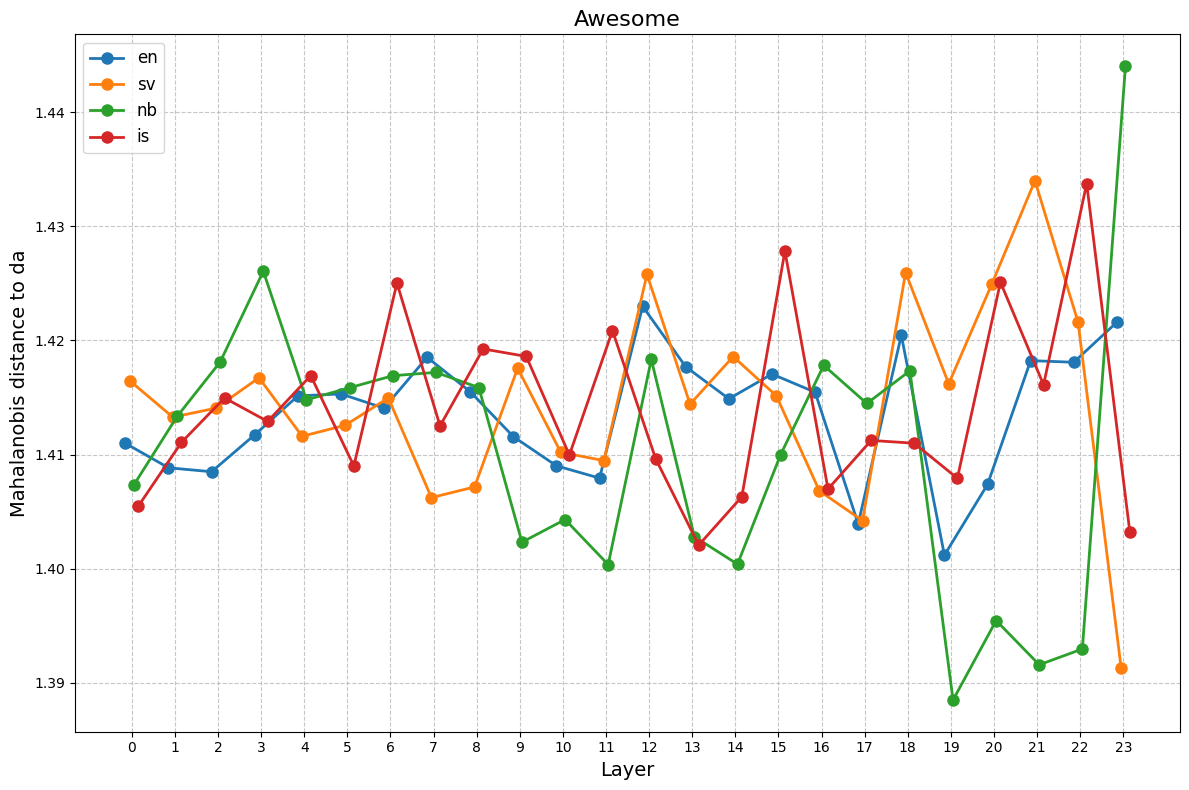

In [20]:
plot_distances(mahalanobis_dict,"da","mahalanobis")

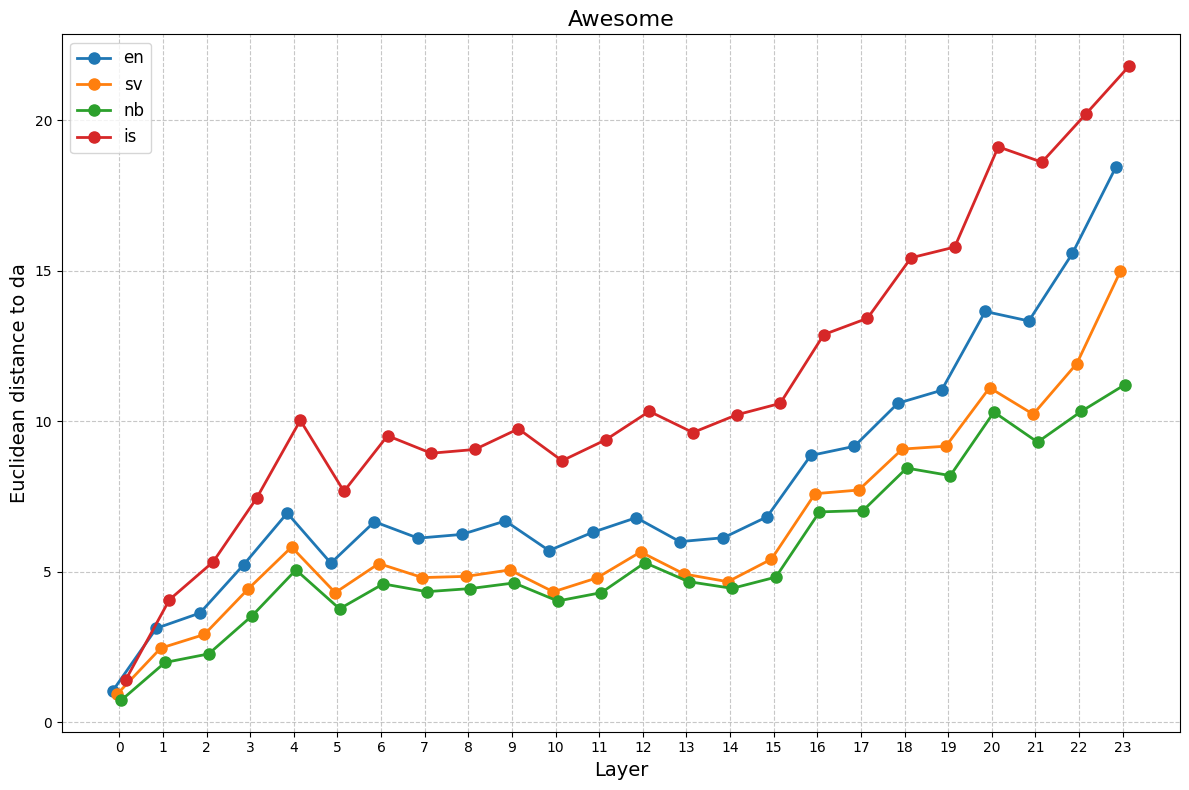

In [21]:
plot_distances(euclidean_dict,"da","euclidean")